<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

Reference: https://www.kaggle.com/shivam017arora/sarcasm-detection-w-lstms-beginner-friendly

### Load Data (3 Marks)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

df_headlines = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Project-SeqNLP-2/Sarcasm_Headlines_Dataset.json", lines=True)
df_headlines.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df_headlines.shape

(26709, 3)

### Drop `article_link` from dataset (3 Marks)

In [5]:
df_headlines.isnull().sum() # checking null values

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [6]:
df_headlines.describe(include='object')

,article_link,headline
count,26709,26709
unique,26708,26602
top,https://www.huffingtonpost.comhttp://nymag.com...,the 20 funniest tweets from women this week
freq,2,10


In [7]:
df_headlines.drop(['article_link'],axis = 1, inplace = True)

In [8]:
df_headlines.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [9]:
# 107 rows of duplicated data
df_headlines[df_headlines.duplicated()]

,headline,is_sarcastic
1091,antarctic observational comic running out of i...,1
2265,sunday roundup,0
2975,the best chance to defeat roy moore may be for...,0
3802,sunday roundup,0
4605,sunday roundup,0
...,...,...
26121,"'no way to prevent this,' says only nation whe...",1
26156,"area man busts his ass all day, and for what?",1
26353,kleenex box inadequately covered,1
26500,candy purchase puts yet more money in raisinet...,1


In [10]:
df_headlines.drop_duplicates(inplace=True)

### Get length of each headline and add a column for that (3 Marks)

In [11]:
df_headlines['len'] = df_headlines['headline'].apply(lambda x: len(x.split(" ")))
df_headlines.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


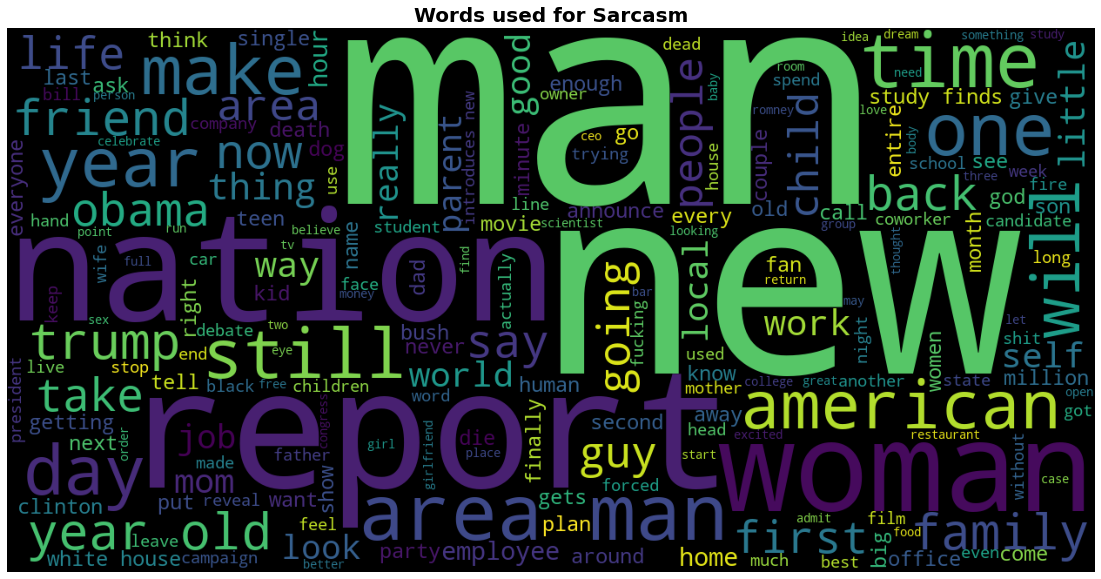

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_keywords = " ".join(line for line in df_headlines[df_headlines.is_sarcastic==1].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

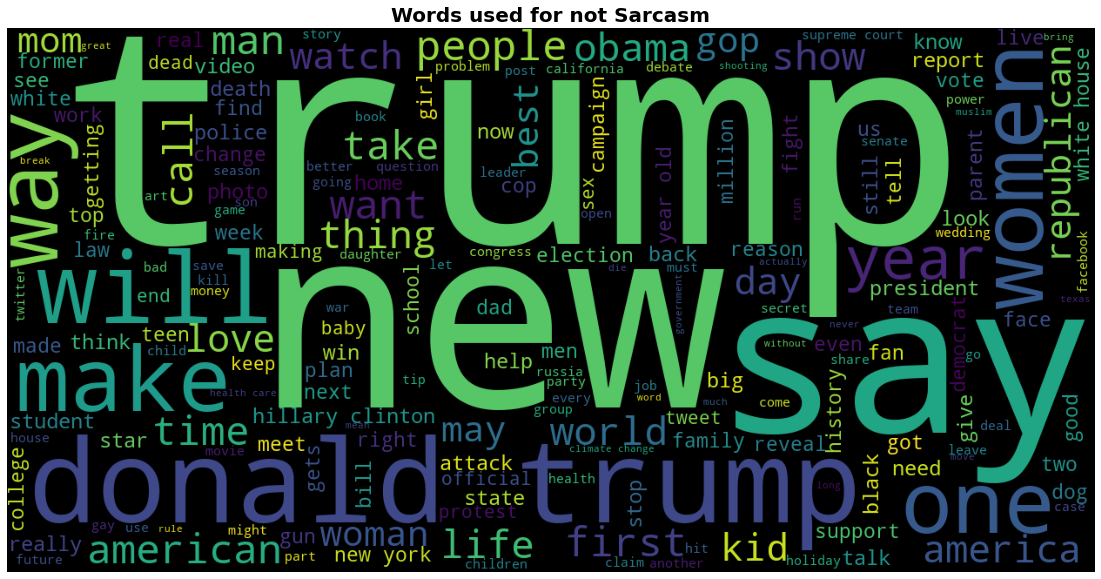

In [13]:
all_keywords = " ".join(line for line in df_headlines[df_headlines.is_sarcastic==0].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for not Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [14]:
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
def clean_headline(headline):
    STOPWORDS = set(stopwords.words("english"))
    headline = headline.lower()
    headline = " ".join(word for word in headline.split() if word not in STOPWORDS)
    headline = "".join(word for word in headline if word not in set(string.punctuation))
    return headline

df_headlines.headline = df_headlines['headline'].apply(lambda x: clean_headline(x))
df_headlines.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,headline,is_sarcastic,len
0,former versace store clerk sues secret black c...,0,12
1,roseanne revival catches thorny political mood...,0,14
2,mom starting fear sons web series closest thin...,1,14
3,boehner wants wife listen come alternative deb...,1,13
4,jk rowling wishes snape happy birthday magical...,0,11


In [15]:
df_headlines.shape

(26602, 3)

In [16]:
df_headlines.to_csv('headlines.csv', index = False)

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [17]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words (4 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [18]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df_headlines['headline']))
X = tokenizer.texts_to_sequences(df_headlines['headline'])

### Pad sequences (4 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [19]:
from sklearn.model_selection import train_test_split
X = pad_sequences(X, maxlen = maxlen)
y = df_headlines['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

(21281, 25) (21281,)
(5321, 25) (5321,)


### Vocab mapping
- There is no word for 0th index

In [20]:
index_words = tokenizer.word_index

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [21]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

28387


### Load Glove Word Embeddings 


In [46]:
#Load pretrained GloVe embeddings
dict_w2v = {}
with open('/content/drive/MyDrive/Colab Notebooks/Project-SeqNLP-2/glove.6B.50d.txt', "r") as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 50:
            dict_w2v[word] = vector
        else:
            print("There was an issue with " + word)
# let's check the vocabulary size
print("Dictionary Size: ", len(dict_w2v))

Dictionary Size:  400000


### Create embedding matrix

In [23]:
EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/Project-SeqNLP-2/glove.6B.50d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix.shape

(28387, 50)

### Define model (5 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

#### SIMPLE RNN

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, Flatten
from keras.initializers import Constant
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
simpleRNN = model = Sequential()

simpleRNN.add(Embedding(input_dim=num_words, output_dim=50, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=maxlen, trainable=False))
simpleRNN.add(SimpleRNN(64, dropout=0.1))
simpleRNN.add(Dense(1, activation='sigmoid'))

simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            1419350   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                7360      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,426,775
Trainable params: 7,425
Non-trainable params: 1,419,350
_________________________________________________________________


In [27]:
history = simpleRNN.fit(X_train, y_train, epochs=20, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 20s 57ms/step - loss: 0.7101 - accuracy: 0.5455 - val_loss: 0.6588 - val_accuracy: 0.6123
Epoch 2/20
21/21 [==============================] - 1s 25ms/step - loss: 0.6421 - accuracy: 0.6374 - val_loss: 0.6317 - val_accuracy: 0.6480
Epoch 3/20
21/21 [==============================] - 0s 24ms/step - loss: 0.6124 - accuracy: 0.6683 - val_loss: 0.6057 - val_accuracy: 0.6758
Epoch 4/20
21/21 [==============================] - 0s 24ms/step - loss: 0.5956 - accuracy: 0.6796 - val_loss: 0.5911 - val_accuracy: 0.6845
Epoch 5/20
21/21 [==============================] - 1s 26ms/step - loss: 0.5866 - accuracy: 0.6895 - val_loss: 0.5805 - val_accuracy: 0.6942
Epoch 6/20
21/21 [==============================] - 1s 24ms/step - loss: 0.5697 - accuracy: 0.7026 - val_loss: 0.5711 - val_accuracy: 0.7070
Epoch 7/20
21/21 [==============================] - 1s 24ms/step - loss: 0.5685 - accuracy: 0.7032 - val_loss: 0.5687 - val_accuracy: 0.7079
Epoch 8/20
2

In [28]:
print(classification_report(y_test, simpleRNN.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      2913
           1       0.74      0.66      0.70      2408

    accuracy                           0.74      5321
   macro avg       0.74      0.73      0.74      5321
weighted avg       0.74      0.74      0.74      5321



#### LSTM

In [29]:
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=num_words, output_dim=50, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=maxlen, trainable=False))
lstm_model.add(LSTM(50, dropout=0.1))
lstm_model.add(Dense(1, activation='sigmoid'))

In [30]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            1419350   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,439,601
Trainable params: 20,251
Non-trainable params: 1,419,350
_________________________________________________________________


In [31]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 5s 42ms/step - loss: 0.6759 - accuracy: 0.5792 - val_loss: 0.6376 - val_accuracy: 0.6463
Epoch 2/20
21/21 [==============================] - 0s 8ms/step - loss: 0.6181 - accuracy: 0.6653 - val_loss: 0.5970 - val_accuracy: 0.6781
Epoch 3/20
21/21 [==============================] - 0s 10ms/step - loss: 0.5830 - accuracy: 0.6891 - val_loss: 0.5722 - val_accuracy: 0.7027
Epoch 4/20
21/21 [==============================] - 0s 8ms/step - loss: 0.5596 - accuracy: 0.7156 - val_loss: 0.5571 - val_accuracy: 0.7108
Epoch 5/20
21/21 [==============================] - 0s 8ms/step - loss: 0.5516 - accuracy: 0.7174 - val_loss: 0.5466 - val_accuracy: 0.7205
Epoch 6/20
21/21 [==============================] - 0s 8ms/step - loss: 0.5305 - accuracy: 0.7336 - val_loss: 0.5348 - val_accuracy: 0.7271
Epoch 7/20
21/21 [==============================] - 0s 8ms/step - loss: 0.5223 - accuracy: 0.7390 - val_loss: 0.5230 - val_accuracy: 0.7363
Epoch 8/20
21/21 [

In [32]:
print(classification_report(y_test, lstm_model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      2913
           1       0.75      0.76      0.75      2408

    accuracy                           0.78      5321
   macro avg       0.77      0.77      0.77      5321
weighted avg       0.78      0.78      0.78      5321



### Bi-directional LSTM

In [33]:
import keras
import keras.metrics as metrics
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, Flatten

biLSTM = Sequential()

biLSTM.add(Embedding(input_dim=num_words, output_dim=50, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=maxlen, trainable=False))
biLSTM.add(Bidirectional(LSTM(units=64, recurrent_dropout = 0.3, dropout = 0.3, 
                             return_sequences = True)))
biLSTM.add(Bidirectional(LSTM(units=32, recurrent_dropout = 0.1, dropout = 0.1)))
biLSTM.add(Flatten(name="Flatten"))
biLSTM.add(Dense(1, activation='sigmoid'))


### Compile the model (4 Marks)

In [34]:
biLSTM.compile(optimizer=keras.optimizers.Adam(lr = 0.01), 
              loss='binary_crossentropy', metrics=['accuracy'])
biLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 50)            1419350   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 128)           58880     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
Flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,519,511
Trainable params: 100,161
Non-trainable params: 1,419,350
_________________________________________________________________


### Fit the model (4 Marks)

In [35]:
history = biLSTM.fit(X_train, y_train, epochs=20, batch_size=1024, 
                    validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 26s 521ms/step - loss: 0.6626 - accuracy: 0.5974 - val_loss: 0.5749 - val_accuracy: 0.6974
Epoch 2/20
21/21 [==============================] - 7s 344ms/step - loss: 0.5665 - accuracy: 0.7070 - val_loss: 0.5228 - val_accuracy: 0.7343
Epoch 3/20
21/21 [==============================] - 7s 340ms/step - loss: 0.5069 - accuracy: 0.7470 - val_loss: 0.4907 - val_accuracy: 0.7591
Epoch 4/20
21/21 [==============================] - 7s 343ms/step - loss: 0.4790 - accuracy: 0.7657 - val_loss: 0.4855 - val_accuracy: 0.7662
Epoch 5/20
21/21 [==============================] - 7s 339ms/step - loss: 0.4500 - accuracy: 0.7832 - val_loss: 0.4699 - val_accuracy: 0.7717
Epoch 6/20
21/21 [==============================] - 7s 340ms/step - loss: 0.4338 - accuracy: 0.7941 - val_loss: 0.4612 - val_accuracy: 0.7732
Epoch 7/20
21/21 [==============================] - 7s 353ms/step - loss: 0.4183 - accuracy: 0.8013 - val_loss: 0.4806 - val_accuracy: 0.7764
Epoch

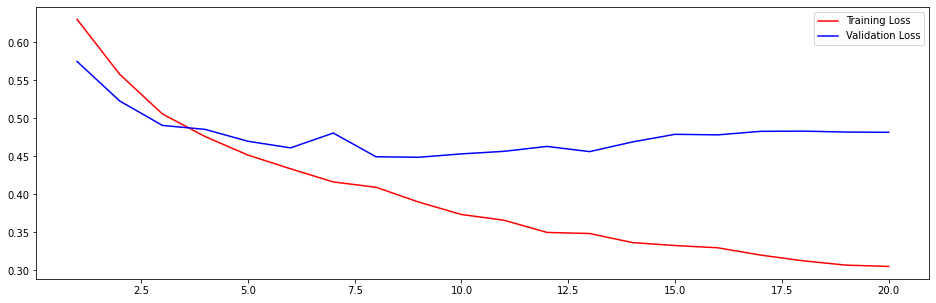

In [36]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

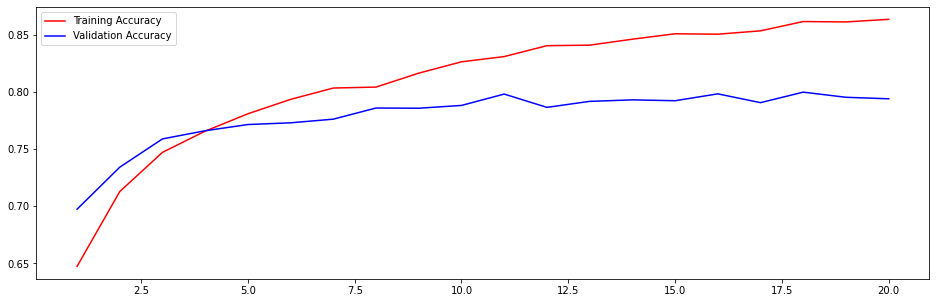

In [37]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

In [38]:
print(classification_report(y_test, biLSTM.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2913
           1       0.77      0.78      0.77      2408

    accuracy                           0.79      5321
   macro avg       0.79      0.79      0.79      5321
weighted avg       0.79      0.79      0.79      5321



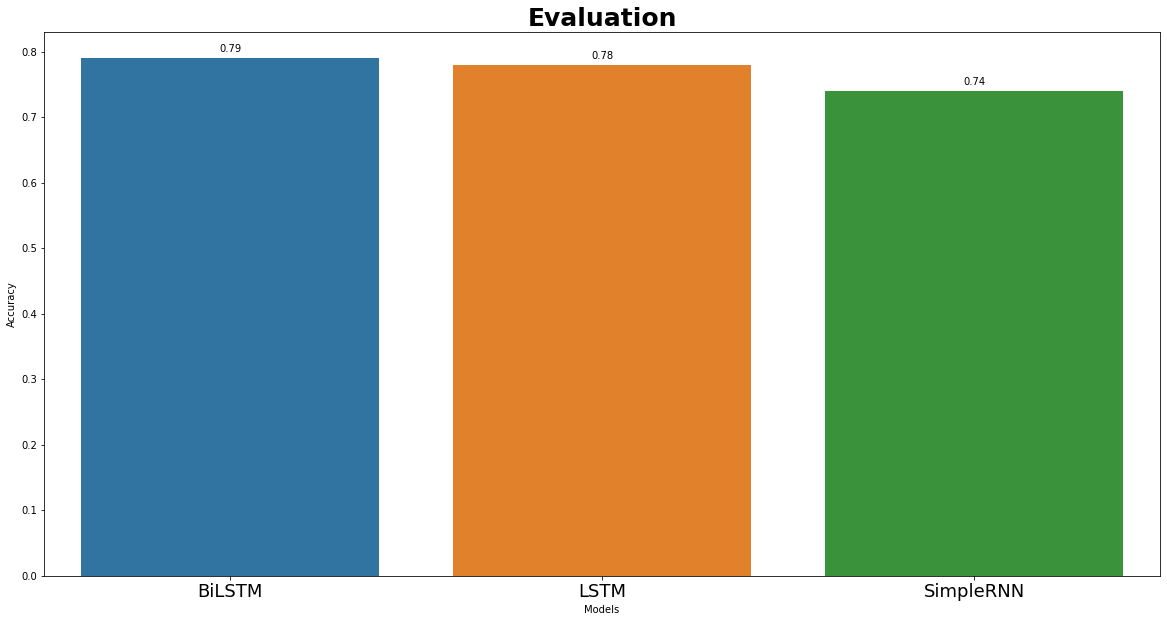

In [39]:
import seaborn as sns
accuracy_simple_rnn = accuracy_score(y_test, simpleRNN.predict_classes(X_test))
accuracy_simple_lstm = accuracy_score(y_test, lstm_model.predict_classes(X_test))
accuracy_bi_lstm = accuracy_score(y_test, biLSTM.predict_classes(X_test))

conclusion = pd.DataFrame({'Models':['SimpleRNN', 'LSTM','BiLSTM'], 
              'Accuracy':[accuracy_simple_rnn, accuracy_simple_lstm, accuracy_bi_lstm]})
conclusion['Accuracy'] = conclusion['Accuracy'].apply(lambda x: round(x,2))
conclusion.sort_values(by='Accuracy', inplace = True, ascending = False)

plt.figure(figsize=(20,10))
seaborn_plot = sns.barplot(conclusion.Models,conclusion.Accuracy)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Evaluation", weight='bold', size=25)
plt.xticks(size=18)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

In [40]:
# the Above graph displays the differences between using Bidirectional LSTM, LSTM and SimpleRNN in identifying sentences for Sarcasm or simply sarcasm detection

###Predictions

In [41]:
key_sarcasm = {0:"Not Sarcastic", 1:"Sarcastic"}

In [42]:
predictions = biLSTM.predict_classes(X_test, verbose =1)

167/167 [==============================] - 4s 22ms/step


In [43]:
y_actual = np.array(y_test)

In [48]:
rnd = np.random.randint(0,len(y_actual))
print('Sample Number: ', rnd)
print('Actual Value: ', key_sarcasm.get(y_actual[rnd]))
print('Predicted Value: ', key_sarcasm.get(predictions[rnd][0]))

Sample Number:  2959
Actual Value:  Sarcastic
Predicted Value:  Sarcastic
